In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid

import os
import glob
import pandas as pd
import json
from dotenv import load_dotenv
from functools import partial

In [2]:
def get_db(data_dir):
    json_files = glob.glob(os.path.join(data_dir, "*.json"))
    data_list = []

    # Iterate through the JSON files and read them
    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)
            data_list.append(data)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data_list)
    return df

In [3]:
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")
output_dir = os.path.join(output_dir, "gray_scott")
os.makedirs(output_dir, exist_ok=True)
model = "gray_scott"
df = get_db(os.path.join(data_dir, model))

In [4]:
df = df[df["run_id"] == "gs_vary_ab"]
df

,model,A,B,Nx,dx,Nt,dt,Du,Dv,sigma_ic,random_seed,n_snapshots,filename,run_id
0,gray_scott,0.030,0.0450,100,1.0,5000,0.0025,2.0,22.0,0.1,1,100,/Users/vv/eth/bachelor/pde-solvers-cuda/data/g...,gs_vary_ab
3,gray_scott,0.042,0.0672,100,1.0,5000,0.0025,2.0,22.0,0.1,1,100,/Users/vv/eth/bachelor/pde-solvers-cuda/data/g...,gs_vary_ab
5,gray_scott,0.044,0.0748,100,1.0,5000,0.0025,2.0,22.0,0.1,1,100,/Users/vv/eth/bachelor/pde-solvers-cuda/data/g...,gs_vary_ab
7,gray_scott,0.042,0.0546,100,1.0,5000,0.0025,2.0,22.0,0.1,1,100,/Users/vv/eth/bachelor/pde-solvers-cuda/data/g...,gs_vary_ab
8,gray_scott,0.030,0.0420,100,1.0,5000,0.0025,2.0,22.0,0.1,1,100,/Users/vv/eth/bachelor/pde-solvers-cuda/data/g...,gs_vary_ab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,gray_scott,0.030,0.0300,100,1.0,500,1.0000,2.0,22.0,0.1,1,100,/Users/vv/eth/bachelor/pde-solvers-cuda/data/g...,gs_vary_ab
144,gray_scott,0.044,0.0616,100,1.0,5000,0.0025,2.0,22.0,0.1,1,100,/Users/vv/eth/bachelor/pde-solvers-cuda/data/g...,gs_vary_ab
145,gray_scott,0.034,0.0408,100,1.0,500,1.0000,2.0,22.0,0.1,1,100,/Users/vv/eth/bachelor/pde-solvers-cuda/data/g...,gs_vary_ab
148,gray_scott,0.034,0.0544,100,1.0,500,1.0000,2.0,22.0,0.1,1,100,/Users/vv/eth/bachelor/pde-solvers-cuda/data/g...,gs_vary_ab


In [5]:
def ab_grid(
    df, component_idx=0, frame=-1, sigdigits=2, var1="A", var2="B", file="", an=False
):
    if len(df) == 0:
        return None

    df = df.sort_values(by=[var1, var2])
    A_count = len(df[var1].unique())
    print(A_count)
    B_count = int(len(df) / A_count)
    print(B_count)
    fig = plt.figure(figsize=(8, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(A_count, B_count), axes_pad=(0.1, 0.3))

    ims = []

    for i, row in df.iterrows():
        ds = nc.Dataset(row["filename"])

        data = ds.variables["data"][:]
        ims.append((row, data[0, frame, :, component_idx::2]))

    for ax, (row, im) in zip(grid, ims):
        ax.set_title(
            f"{var1}={row[var1]:.{sigdigits}f}\n{var2} = {row[var2]:.{sigdigits}f}",
            fontsize=6,
        )
        ax.imshow(im, cmap="viridis")
        ax.set_aspect("equal")
        ax.axis("off")
    row = df.iloc[0]
    if frame == -1:
        time = row["dt"] * row["Nt"]
    else:
        time = row["dt"] * frame * row["Nt"] / row["n_snapshots"]
    fig.suptitle(
        f"{row['model'].capitalize()}, Nx={row['Nx']}, dx={row['dx']}, dt={row['dt']}, T={time:.2f}",
        fontsize=16,
    )

    if file != "":
        plt.savefig(file, dpi=100)
    if not an:
        plt.show()
    return grid


9
12


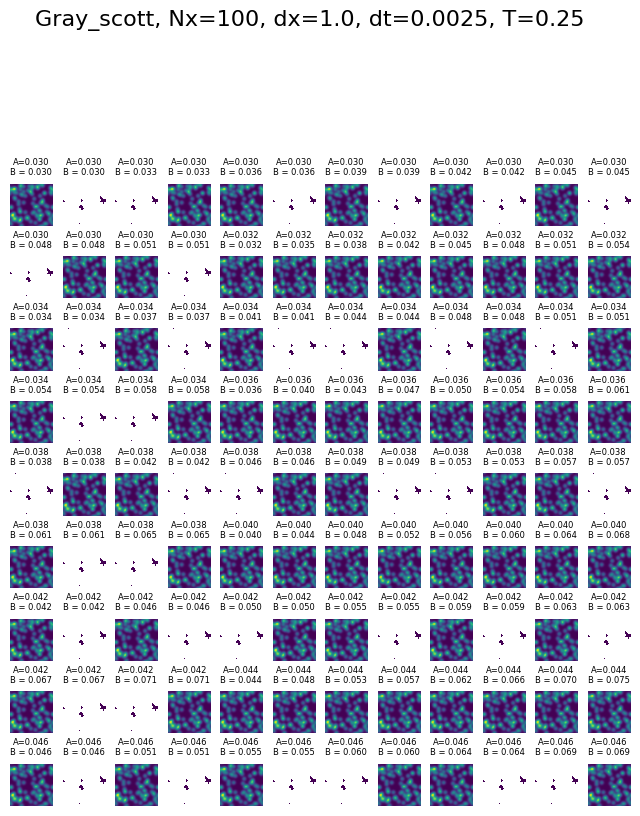

In [6]:
ab_grid(df, 1, frame=2, sigdigits=3, var1="A", var2="B")

In [7]:
def snapshot_grid(df, column, component_idx=0, n_images=5, sigdigits=2):
    df_filtered = df.sort_values(by=column)

    count = len(df_filtered)
    fig = plt.figure(figsize=(20, 24))
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=(count, n_images),
        axes_pad=0.5,  # pad between Axes in inch.
    )

    ims = []

    for i, row in df_filtered.iterrows():
        ds = nc.Dataset(row["filename"])
        data = ds.variables["data"][:]
        for j in range(n_images):
            frame_idx = int(row["n_snapshots"] * j / n_images)
            ims.append((j, row, data[0, frame_idx, :, component_idx::2]))
    
    for ax, (j, row, im) in zip(grid, ims):
        if j == 0:
            ax.set_title(f"A={row['A']:.{sigdigits}f} B = {row['B']:.{sigdigits}f}")
        else:
            frame_idx = int(row["n_snapshots"] * j / n_images)
            t = row["dt"] * row["Nt"] / row["n_snapshots"] * frame_idx
            ax.set_title(f"t={t:.{sigdigits}f}")
        ax.imshow(im, cmap="viridis")
        ax.set_aspect("equal")
        ax.axis("off")
    
    plt.show()

In [8]:
# df_a = df[df["A"] == 5.0]
# snapshot_grid(df_a, "A")

In [9]:
def plot(data):
    global_min = np.min(data)
    global_max = np.max(data)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

    coupled_idx = 0
    # Display the first snapshot initially; this will be updated in the animation
    matrix = data[0, 0, :, coupled_idx::2]
    im = ax.imshow(
        matrix, cmap="viridis", aspect="equal", vmin=global_min, vmax=global_max
    )
    return fig, ax, im


In [10]:
def animate(snapshot, coupled_idx, data, im, ax):
    matrix = data[0, snapshot, :, coupled_idx::2]
    im.set_array(matrix)  # Update data for each coupled component
    name = "u" if coupled_idx == 0 else "v"
    # ax.set_title(
    #     f"Snapshot {snapshot + 1}, {name}"
    # )
    return [im]

In [11]:
def make_animation(data, param, out_dir):
    fig, ax, im = plot(data)
    ani = animation.FuncAnimation(
        fig,
        partial(animate, coupled_idx=1, data=data, im=im, ax=ax),
        frames=data.shape[1],
        interval=100,
        blit=True,
    )
    out_name = os.path.join(out_dir, f"{param}_output.mp4")
    ani.save(out_name, writer="ffmpeg", dpi=150)
    plt.close(fig)


In [33]:
row = df.iloc[1]
print(row['A'], row['B'], row['dt'], row['Dv'])
ds = nc.Dataset(row["filename"])
data = ds.variables["data"][:]
make_animation(data, "test", output_dir)

0.042 0.06720000000000001 0.0025 22.0


In [31]:
np.sum(data[0, -1, :, 1::2])

np.float32(28.183853)

In [ ]:
def save_final_frame(data, param, out_dir):
    fig, ax, ims = plot(data)
    animate(data.shape[1] - 1, 1, data, ims, ax)
    plt.savefig(os.path.join(out_dir, f"{param}_final.png"))
    plt.close()


In [26]:
save_final_frame(data, "A5", output_dir)